In [8]:
import math
import torch
import torch.nn as nn
from torch import Tensor
from typing import Optional as _Optional
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
torch.cuda.get_device_name(0)

'Tesla V100-PCIE-32GB'

In [10]:
class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x):
        x = self.dwconv(x)
        return x

def _no_grad_trunc_normal_(tensor, mean, std, a, b, generator=None):
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1, generator=generator)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor
    
def trunc_normal_(
    tensor: Tensor,
    mean: float = 0.,
    std: float = 1.,
    a: float = -2.,
    b: float = 2.,
    generator: _Optional[torch.Generator] = None
) -> Tensor:

    return _no_grad_trunc_normal_(tensor, mean, std, a, b, generator=generator)

def drop_path(x, drop_prob: float = 0., training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob: float = 0., scale_by_keep: bool = True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)

    def extra_repr(self):
        return f'drop_prob={round(self.drop_prob,3):0.3f}'

    
class MixMlp(nn.Module):
    def __init__(self,
                 in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)  # 1x1
        self.dwconv = DWConv(hidden_features)                  # CFF: Convlutional feed-forward network
        self.act = act_layer()                                 # GELU
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1) # 1x1
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dwconv(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class BasicConv2d(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1,
                 upsampling=False,
                 act_norm=False,
                 act_inplace=True):
        super(BasicConv2d, self).__init__()
        self.act_norm = act_norm
        if upsampling is True:
            self.conv = nn.Sequential(*[
                nn.Conv2d(in_channels, out_channels*4, kernel_size=kernel_size,
                          stride=1, padding=padding, dilation=dilation),
                nn.PixelShuffle(2)
            ])
        else:
            self.conv = nn.Conv2d(
                in_channels, out_channels, kernel_size=kernel_size,
                stride=stride, padding=padding, dilation=dilation)

        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.SiLU(inplace=act_inplace)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


class ConvSC(nn.Module):

    def __init__(self,
                 C_in,
                 C_out,
                 kernel_size=3,
                 downsampling=False,
                 upsampling=False,
                 act_norm=True,
                 act_inplace=True):
        super(ConvSC, self).__init__()

        stride = 2 if downsampling is True else 1
        padding = (kernel_size - stride + 1) // 2

        self.conv = BasicConv2d(C_in, C_out, kernel_size=kernel_size, stride=stride,
                                upsampling=upsampling, padding=padding,
                                act_norm=act_norm, act_inplace=act_inplace)

    def forward(self, x):
        y = self.conv(x)
        return y


class GroupConv2d(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 groups=1,
                 act_norm=False,
                 act_inplace=True):
        super(GroupConv2d, self).__init__()
        self.act_norm=act_norm
        if in_channels % groups != 0:
            groups=1
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, groups=groups)
        self.norm = nn.GroupNorm(groups,out_channels)
        self.activate = nn.LeakyReLU(0.2, inplace=act_inplace)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.activate(self.norm(y))
        return y


class gInception_ST(nn.Module):
    """A IncepU block for SimVP"""

    def __init__(self, C_in, C_hid, C_out, incep_ker = [3,5,7,11], groups = 8):        
        super(gInception_ST, self).__init__()
        self.conv1 = nn.Conv2d(C_in, C_hid, kernel_size=1, stride=1, padding=0)

        layers = []
        for ker in incep_ker:
            layers.append(GroupConv2d(
                C_hid, C_out, kernel_size=ker, stride=1,
                padding=ker//2, groups=groups, act_norm=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y


class AttentionModule(nn.Module):
    """Large Kernel Attention for SimVP"""

    def __init__(self, dim, kernel_size, dilation=3):
        super().__init__()
        d_k = 2 * dilation - 1
        d_p = (d_k - 1) // 2
        dd_k = kernel_size // dilation + ((kernel_size // dilation) % 2 - 1)
        dd_p = (dilation * (dd_k - 1) // 2)

        self.conv0 = nn.Conv2d(dim, dim, d_k, padding=d_p, groups=dim)
        self.conv_spatial = nn.Conv2d(
            dim, dim, dd_k, stride=1, padding=dd_p, groups=dim, dilation=dilation)
        self.conv1 = nn.Conv2d(dim, 2*dim, 1)

    def forward(self, x):
        u = x.clone()
        attn = self.conv0(x)           # depth-wise conv
        attn = self.conv_spatial(attn) # depth-wise dilation convolution
        
        f_g = self.conv1(attn)
        split_dim = f_g.shape[1] // 2
        f_x, g_x = torch.split(f_g, split_dim, dim=1)
        return torch.sigmoid(g_x) * f_x


class SpatialAttention(nn.Module):
    """A Spatial Attention block for SimVP"""

    def __init__(self, d_model, kernel_size=21, attn_shortcut=True):
        super().__init__()

        self.proj_1 = nn.Conv2d(d_model, d_model, 1)         # 1x1 conv
        self.activation = nn.GELU()                          # GELU
        self.spatial_gating_unit = AttentionModule(d_model, kernel_size)
        self.proj_2 = nn.Conv2d(d_model, d_model, 1)         # 1x1 conv
        self.attn_shortcut = attn_shortcut

    def forward(self, x):
        if self.attn_shortcut:
            shortcut = x.clone()
        x = self.proj_1(x)
        x = self.activation(x)
        x = self.spatial_gating_unit(x)
        x = self.proj_2(x)
        if self.attn_shortcut:
            x = x + shortcut
        return x


class GASubBlock(nn.Module):
    """A GABlock (gSTA) for SimVP"""

    def __init__(self, dim, kernel_size=21, mlp_ratio=4.,
                 drop=0., drop_path=0.1, init_value=1e-2, act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.BatchNorm2d(dim)
        self.attn = SpatialAttention(dim, kernel_size)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.norm2 = nn.BatchNorm2d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MixMlp(
            in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.layer_scale_1 = nn.Parameter(init_value * torch.ones((dim)), requires_grad=True)
        self.layer_scale_2 = nn.Parameter(init_value * torch.ones((dim)), requires_grad=True)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'layer_scale_1', 'layer_scale_2'}

    def forward(self, x):
        x = x + self.drop_path(
            self.layer_scale_1.unsqueeze(-1).unsqueeze(-1) * self.attn(self.norm1(x)))
        x = x + self.drop_path(
            self.layer_scale_2.unsqueeze(-1).unsqueeze(-1) * self.mlp(self.norm2(x)))
        return x


In [11]:
class SimVP_Model(nn.Module):


    def __init__(self, in_shape, hid_S=16, hid_T=256, N_S=4, N_T=4, model_type='gSTA',
                 mlp_ratio=8., drop=0.0, drop_path=0.0, spatio_kernel_enc=3,
                 spatio_kernel_dec=3, act_inplace=True, **kwargs):
        super(SimVP_Model, self).__init__()
        T, C, H, W = in_shape  # T is pre_seq_length
        H, W = int(H / 2**(N_S/2)), int(W / 2**(N_S/2))  # downsample 1 / 2**(N_S/2)
        act_inplace = False
        self.enc = Encoder(C, hid_S, N_S, spatio_kernel_enc, act_inplace=act_inplace)
        self.dec = Decoder(hid_S, C, N_S, spatio_kernel_dec, act_inplace=act_inplace)

        model_type = 'gsta' if model_type is None else model_type.lower()
        if model_type == 'incepu':
            self.hid = MidIncepNet(T*hid_S, hid_T, N_T)
        else:
            self.hid = MidMetaNet(T*hid_S, hid_T, N_T,
                input_resolution=(H, W), model_type=model_type,
                mlp_ratio=mlp_ratio, drop=drop, drop_path=drop_path)

    def forward(self, x_raw, **kwargs):
        B, T, C, H, W = x_raw.shape
        x = x_raw.reshape(B*T, C, H, W)

        embed, skip = self.enc(x)
        _, C_, H_, W_ = embed.shape

        z = embed.view(B, T, C_, H_, W_)
        hid = self.hid(z)
        hid = hid.reshape(B*T, C_, H_, W_)

        Y = self.dec(hid, skip)
        Y = Y.reshape(B, T, C, H, W)

        return Y


def sampling_generator(N, reverse=False):
    samplings = [False, True] * (N // 2)
    if reverse: return list(reversed(samplings[:N]))
    else: return samplings[:N]


class Encoder(nn.Module):
    """3D Encoder for SimVP"""

    def __init__(self, C_in, C_hid, N_S, spatio_kernel, act_inplace=True):
        samplings = sampling_generator(N_S)
        super(Encoder, self).__init__()
        self.enc = nn.Sequential(
              ConvSC(C_in, C_hid, spatio_kernel, downsampling=samplings[0],
                     act_inplace=act_inplace),
            *[ConvSC(C_hid, C_hid, spatio_kernel, downsampling=s,
                     act_inplace=act_inplace) for s in samplings[1:]]
        )

    def forward(self, x):  # B*4, 3, 128, 128
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1, len(self.enc)):
            latent = self.enc[i](latent)
        return latent, enc1


class Decoder(nn.Module):
    """3D Decoder for SimVP"""

    def __init__(self, C_hid, C_out, N_S, spatio_kernel, act_inplace=True):
        samplings = sampling_generator(N_S, reverse=True)
        super(Decoder, self).__init__()
        self.dec = nn.Sequential(
            *[ConvSC(C_hid, C_hid, spatio_kernel, upsampling=s,
                     act_inplace=act_inplace) for s in samplings[:-1]],
              ConvSC(C_hid, C_hid, spatio_kernel, upsampling=samplings[-1],
                     act_inplace=act_inplace)
        )
        self.readout = nn.Conv2d(C_hid, C_out, 1)

    def forward(self, hid, enc1=None):
        for i in range(0, len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](hid + enc1)
        Y = self.readout(Y)
        return Y


class MidIncepNet(nn.Module):
    """The hidden Translator of IncepNet for SimVPv1"""

    def __init__(self, channel_in, channel_hid, N2, incep_ker=[3,5,7,11], groups=8, **kwargs):
        super(MidIncepNet, self).__init__()
        assert N2 >= 2 and len(incep_ker) > 1
        self.N2 = N2
        enc_layers = [gInception_ST(
            channel_in, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1,N2-1):
            enc_layers.append(
                gInception_ST(channel_hid, channel_hid//2, channel_hid,
                              incep_ker=incep_ker, groups=groups))
        enc_layers.append(
                gInception_ST(channel_hid, channel_hid//2, channel_hid,
                              incep_ker=incep_ker, groups=groups))
        dec_layers = [
                gInception_ST(channel_hid, channel_hid//2, channel_hid,
                              incep_ker=incep_ker, groups=groups)]
        for i in range(1,N2-1):
            dec_layers.append(
                gInception_ST(2*channel_hid, channel_hid//2, channel_hid,
                              incep_ker=incep_ker, groups=groups))
        dec_layers.append(
                gInception_ST(2*channel_hid, channel_hid//2, channel_in,
                              incep_ker=incep_ker, groups=groups))

        self.enc = nn.Sequential(*enc_layers)
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)

        # encoder
        skips = []
        z = x
        for i in range(self.N2):
            z = self.enc[i](z)
            if i < self.N2-1:
                skips.append(z)
        # decoder
        z = self.dec[0](z)
        for i in range(1,self.N2):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1) )

        y = z.reshape(B, T, C, H, W)
        return y


class MetaBlock(nn.Module):
    """The hidden Translator of MetaFormer for SimVP"""

    def __init__(self, in_channels, out_channels, input_resolution=None, model_type=None,
                 mlp_ratio=8., drop=0.0, drop_path=0.0, layer_i=0):
        super(MetaBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        model_type = model_type.lower() if model_type is not None else 'gsta'

        if model_type == 'gsta':
            self.block = GASubBlock(
                in_channels, kernel_size=21, mlp_ratio=mlp_ratio,
                drop=drop, drop_path=drop_path, act_layer=nn.GELU)
        else:
            assert False and "Invalid model_type in SimVP"

        if in_channels != out_channels:
            self.reduction = nn.Conv2d(
                in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        z = self.block(x)
        return z if self.in_channels == self.out_channels else self.reduction(z)


class MidMetaNet(nn.Module):
    """The hidden Translator of MetaFormer for SimVP"""

    def __init__(self, channel_in, channel_hid, N2,
                 input_resolution=None, model_type=None,
                 mlp_ratio=4., drop=0.0, drop_path=0.1):
        super(MidMetaNet, self).__init__()
        assert N2 >= 2 and mlp_ratio > 1
        self.N2 = N2
        dpr = [  # stochastic depth decay rule
            x.item() for x in torch.linspace(1e-2, drop_path, self.N2)]

        # downsample
        enc_layers = [MetaBlock(
            channel_in, channel_hid, input_resolution, model_type,
            mlp_ratio, drop, drop_path=dpr[0], layer_i=0)]
        # middle layers
        for i in range(1, N2-1):
            enc_layers.append(MetaBlock(
                channel_hid, channel_hid, input_resolution, model_type,
                mlp_ratio, drop, drop_path=dpr[i], layer_i=i))
        # upsample
        enc_layers.append(MetaBlock(
            channel_hid, channel_in, input_resolution, model_type,
            mlp_ratio, drop, drop_path=drop_path, layer_i=N2-1))
        self.enc = nn.Sequential(*enc_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)

        z = x
        for i in range(self.N2):
            z = self.enc[i](z)

        y = z.reshape(B, T, C, H, W)
        return y

In [12]:
model =  SimVP_Model(in_shape=(11,1,160,240)).to(device)
optim = Adam(model.parameters(), lr=1e-3,weight_decay=0.001)
dataset_path = '/scratch/py2050/Dataset_Student/' # modify to suit your own need

In [13]:
# extract all the masks and put into one .npy file for future use
# import matplotlib.pyplot as plt 
# import numpy as np
# import glob
# import os, sys

# fpath ="/scratch/py2050/Dataset_Student/my_array.npy"
# npyfilespath ="/scratch/py2050/Dataset_Student/train/**/*.npy"   
# npfiles= glob.glob(npyfilespath,recursive=True)
# npfiles.sort()
# all_arrays = []
# for i, npfile in enumerate(npfiles):
#     all_arrays.append(np.load(os.path.join(npfile)))
# np.save(fpath, np.stack(all_arrays))

In [14]:
def collate(batch):
    batch=torch.tensor(np.array(batch))
    batch = batch.to(device)

    return batch[:,:,0:11], batch[:,:,11:]

def load_dataset(train_dataset):
    train_data= torch.tensor(train_dataset.astype(np.float32)).unsqueeze(1).numpy()
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True,drop_last=True, collate_fn=collate)
    return train_loader


train_dataset = np.load("/scratch/py2050/Dataset_Student/my_array.npy")
print(train_dataset.shape)
train_loader=load_dataset(train_dataset)

(1000, 22, 160, 240)


In [15]:
# %pip install opencv-python

In [16]:
# import cv2
# testpath ="/scratch/py2050/Dataset_Student/my_test_array.npy"
# pngfilespath ="/scratch/py2050/Dataset_Student/train/**/*.png"   
# pngfiles= glob.glob(pngfilespath,recursive=True)

# pngfiles.sort()
# all_arrays = []
# for i, pngfile in enumerate(pngfiles):
#     img = cv2.imread(os.path.join(pngfile))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     all_arrays.append(img)
# np.save(testpath, np.stack(all_arrays))

In [17]:
test_dataset = np.load("/scratch/py2050/Dataset_Student/my_test_array.npy")
print(test_dataset.shape)


(22000, 160, 240, 3)


In [18]:
test_loader=load_dataset(test_dataset)

In [15]:
def load_model(path,lr,weight_decay):
    model=torch.load(path)
    optim = Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
    return model,optim

In [16]:
# model,optim=load_model('/home/yz10727/data/best_model_Simvp_gsta.pth',lr=0.001,weight_decay=0.0002)

criterion = nn.MSELoss()
num_epochs = 100
best_val_acc=1


for epoch in range(1, num_epochs+1):
    print(epoch)
    train_loss = 0                                                 
    model.train()
    
    for batch_num, (input, target) in enumerate(train_loader): 
        input = torch.permute(input, (0,2,1,3,4))

        output = model(input) 
        loss = criterion(output, target)   

        loss.backward()   
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()                                 
    train_loss /= len(train_loader.dataset)                       
                                                                    
    print("Epoch:{} Training Loss:{:.4f}\n".format(epoch, train_loss))
    if best_val_acc>train_loss:
        best_val_acc = train_loss
        torch.save( model, "/scratch/py2050/best_simVP_gSTA.pth")  
        print('saved')

1


/home/py2050/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 11, 160, 240])) that is different to the input size (torch.Size([32, 11, 1, 160, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:1 Training Loss:1.1604

2
Epoch:2 Training Loss:1.0576

3
Epoch:3 Training Loss:0.9962

saved
4
Epoch:4 Training Loss:0.9368

saved
5
Epoch:5 Training Loss:0.8998

saved
6
Epoch:6 Training Loss:0.8693

saved
7
Epoch:7 Training Loss:0.8431

saved
8
Epoch:8 Training Loss:0.8263

saved
9
Epoch:9 Training Loss:0.7966

saved
10
Epoch:10 Training Loss:0.7737

saved
11
Epoch:11 Training Loss:0.7463

saved
12
Epoch:12 Training Loss:0.7359

saved
13
Epoch:13 Training Loss:0.7133

saved
14
Epoch:14 Training Loss:0.7055

saved
15
Epoch:15 Training Loss:0.6963

saved
16
Epoch:16 Training Loss:0.6867

saved
17
Epoch:17 Training Loss:0.6888

18
Epoch:18 Training Loss:0.6778

saved
19
Epoch:19 Training Loss:0.6704

saved
20
Epoch:20 Training Loss:0.6635

saved
21
Epoch:21 Training Loss:0.6535

saved
22
Epoch:22 Training Loss:0.6483

saved
23
Epoch:23 Training Loss:0.6502

24
Epoch:24 Training Loss:0.6413

saved
25
Epoch:25 Training Loss:0.6421

26
Epoch:26 Training Loss:0.6400

saved
27
Epoch:2

KeyboardInterrupt: 

/home/py2050/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/py2050/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


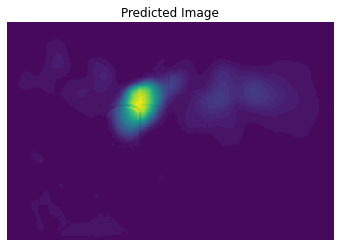

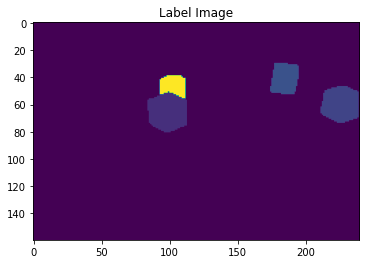

In [20]:
import matplotlib.pyplot as plt
model_path = '/scratch/py2050/best_simVP_gSTA.pth'
def results_display(data,model_path,num):
    model=torch.load(model_path).to(device)
    data_test= torch.tensor(data.astype(np.float32)).unsqueeze(1)
    data_test= torch.permute(data_test, (0,2,1,3,4))
    data_test=torch.tensor(np.array(data_test)).to(device)
    output = model(data_test[num,0:11].unsqueeze(0))
    plt.imshow(np.rint(output.squeeze(0)[10].squeeze(0).cpu().detach().numpy()))
    plt.axis('off')  
    plt.title('Predicted Image')
    plt.show()
    plt.imshow(data[num,21])
    plt.title('Label Image')
    plt.show()

            
model_path="/scratch/py2050/best_simVP_gSTA.pth"
data=np.load("/scratch/py2050/Dataset_Student/my_array.npy")
num=1
results_display(data[1:],model_path,num)

In [22]:

model_path = "/scratch/py2050/best_simVP_gSTA.pth"
model=torch.load(model_path).to(device)
print('\nRunning Inference ...')
model.eval()
masks_test = np.zeros((0, 160, 240))

for i, x in enumerate(test_loader):
#     x = x.to(device)
    with torch.no_grad():
        y = model(x)
        out = y['out']
    masks_batch = out.cpu().detach().numpy().argmax(1)
    masks_test = np.concatenate([masks_test, masks_batch], axis=0)
    if (i+1) % 100 == 0:
        print(f'Batch {i+1} / {len(test_loader)}')

assert masks_test.shape == (2000, 160, 240)

    # save
np.save(exp_dir + 'masks_hidden.npy', masks_test)
print(f'\nMasks saved. Shape: {masks_test.shape}')


Running Inference ...


AttributeError: 'tuple' object has no attribute 'shape'